# Ex - Univariate Time Series Prediction

Here we will try using decision trees for a regression task, namely the time series prediction problem from the previous lecture.

## First of All...

If you are using this notebook from Google Colab, you need to fetch the necessary resources by running:

In [ ]:
!mkdir resources
!wget https://raw.githubusercontent.com/lompabo/bbs2019dtm/master/lab02/resources/AirQualityUCI.csv
!mv AirQualityUCI.csv resources
!wget https://raw.githubusercontent.com/lompabo/bbs2019dtm/master/lab02/resources/lr_train.txt
!mv lr_train.txt resources/
!wget https://raw.githubusercontent.com/lompabo/bbs2019dtm/master/lab02/resources/lr_test.txt
!mv lr_test.txt resources/
!wget https://raw.githubusercontent.com/lompabo/bbs2019dtm/master/lab02/lutil.py

Here is the code to load and preprocess the data. This time, we will take two non-contiguous time steps, namely te current one and the one 24 hours earlier.

Note that, since we are dropping all rows containin NaN values, the sequence will be off at times: it would be better to apply the sliding window to each block of contiguous rows separately, but for this exercise we will choose simplicity over correctness.

Start by trying to learn a linear and a tree-based (random forest) regressor for the univariate case. Then see what happens by including additional features. Try to manage overfitting for the Random Forest regressor.

In [1]:
import lutil
import numpy as np

# Load data
data = lutil.load_air_data()
data = data.dropna() # Discard tuples with NaN values

# Univariate time series (discard all columns but one)
data = data[['CO(GT)']]

# Choose a separator date for the training and test set
# NOTE: it's important to compute the means and standard deviations only on the training data!
sep = data.index[-500]

# Standardize the data
means = data[data.index < sep].mean(axis=0)
stds = data[data.index < sep].std(axis=0)
data = (data - means) / stds

# Build a dataset using a sliding window approach
targets = ['CO(GT)']
steps_in = [0,23]
index, x_all, y_all = lutil.sliding_win_ds(data, targets, steps_in)

print('Original shape of the input data: %s' % str(x_all.shape))
print('Original shape of the output data: %s' % str(y_all.shape))

x_all = x_all.reshape(len(x_all), -1)
y_all = y_all.reshape(len(y_all), -1)

# Separate training and test set
train_mask = index < sep
x_train, y_train = x_all[train_mask], y_all[train_mask]
index_train = index[train_mask]
test_mask = index >= sep
x_test, y_test = x_all[test_mask], y_all[test_mask]
index_test = index[test_mask]

Original shape of the input data: (803, 2, 1)
Original shape of the output data: (803, 1, 1)


/Users/lompa/Documents/Teaching/BBS 2019 - Master in Digital Technology Management/lab02/lutil.py:209: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  x = np.stack( (data[i:-totwidth+i+1 or None:sliding_step] for i in steps_in), axis=1)
/Users/lompa/Documents/Teaching/BBS 2019 - Master in Digital Technology Management/lab02/lutil.py:210: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  y = np.stack( (data[i:-totwidth+i+1 or None:sliding_step][targets] for i in steps_out), axis=1)


Here is the code to train a linear regressor:

In [2]:
from sklearn import linear_model
from sklearn import metrics

# Build the model
model = linear_model.LinearRegression()
# Training
model.fit(x_train, y_train)

# Obtain predictions
pred_train = model.predict(x_train)
pred_test = model.predict(x_test)

# Evaluate
mae_train = metrics.mean_absolute_error(y_train, pred_train)
r2_train = metrics.r2_score(y_train, pred_train)

mae_test = metrics.mean_absolute_error(y_test, pred_test)
r2_test = metrics.r2_score(y_test, pred_test)

print('MAE, training set (model): %f' % (mae_train))
print('MAE, test set (model): %f' % (mae_test))
print('R2, training set (model): %f' % (r2_train))
print('R2, test set (model): %f' % (r2_test))

MAE, training set (model): 0.465213
MAE, test set (model): 0.454466
R2, training set (model): 0.553735
R2, test set (model): 0.625124


And here's how to train a Random Forest regressor:

MAE, training set (model): 0.230954
MAE, test set (model): 0.527681
R2, training set (model): 0.873783
R2, test set (model): 0.446821


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


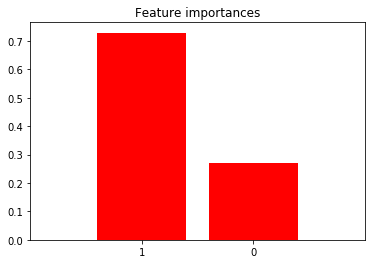

In [3]:
from sklearn import ensemble
from sklearn import metrics
from matplotlib import pyplot as plt

# Build the model
model = ensemble.RandomForestRegressor()
# Training
model.fit(x_train, y_train)

# Obtain predictions
pred_train = model.predict(x_train)
pred_test = model.predict(x_test)

# Evaluate
mae_train = metrics.mean_absolute_error(y_train, pred_train)
r2_train = metrics.r2_score(y_train, pred_train)

mae_test = metrics.mean_absolute_error(y_test, pred_test)
r2_test = metrics.r2_score(y_test, pred_test)

print('MAE, training set (model): %f' % (mae_train))
print('MAE, test set (model): %f' % (mae_test))
print('R2, training set (model): %f' % (r2_train))
print('R2, test set (model): %f' % (r2_test))

# Plot importance scores
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure()
plt.title("Feature importances")
plt.bar(range(x_train.shape[1]), importances[indices], color="r", align="center")
plt.xticks(range(x_train.shape[1]), indices)
plt.xlim([-1, x_train.shape[1]])
plt.show()